# RO47019: Intelligent Control Systems Practical Assignment
* Period: 2022-2023, Q3
* Course homepage: https://brightspace.tudelft.nl/d2l/home/500969
* Instructor: Cosimo Della Santina (C.DellaSantina@tudelft.nl)
* Teaching assistant: Ruben Martin Rodriguez (R.MartinRodriguez@student.tudelft.nl)
* (c) TU Delft, 2023

Make sure you fill in any place that says `YOUR CODE HERE` or `YOUR ANSWER HERE`. Remove `raise NotImplementedError()` afterwards. Moreover, if you see an empty cell, please DO NOT delete it, instead run that cell as you would run all other cells. Please fill in your name(s) and other required details below:

In [1]:
# Please fill in your names, student numbers, netID, and emails below.
STUDENT_1_NAME = "Zekai Chen"
STUDENT_1_STUDENT_NUMBER = "5705762"
STUDENT_1_NETID = "zchen12"
STUDENT_1_EMAIL = "Z.Chen-58@student.tudelft.nl"

In [2]:
# Note: this block is a check that you have filled in the above information.
# It will throw an AssertionError until all fields are filled
assert STUDENT_1_NAME != ""
assert STUDENT_1_STUDENT_NUMBER != ""
assert STUDENT_1_NETID != ""
assert STUDENT_1_EMAIL != ""

### General announcements

* Do *not* share your solutions, and do *not* copy solutions from others. By submitting your solutions, you claim that you alone are responsible for this code.

* Do *not* email questions directly, since we want to provide everybody with the same information and avoid repeating the same answers. Instead, please post your questions regarding this assignment in the correct support forum on Brightspace, this way everybody can benefit from the response. If you do have a particular question that you want to ask directly, please use the scheduled Q&A hours to ask the TA.

* There is a strict deadline for each assignment. Students are responsible to ensure that they have uploaded their work in time. So, please double check that your upload succeeded to the Brightspace and avoid any late penalties.

* This [Jupyter notebook](https://jupyter.org/) uses `nbgrader` to help us with automated tests. `nbgrader` will make various cells in this notebook "uneditable" or "unremovable" and gives them a special id in the cell metadata. This way, when we run our checks, the system will check the existence of the cell ids and verify the number of points and which checks must be run. While there are ways that you can edit the metadata and work around the restrictions to delete or modify these special cells, you should not do that since then our nbgrader backend will not be able to parse your notebook and give you points for the assignment. You are free to add additional cells, but if you find a cell that you cannot modify or remove, please know that this is on purpose.

* This notebook will have in various places a line that throws a `NotImplementedError` exception. These are locations where the assignment requires you to adapt the code! These lines are just there as a reminder for youthat you have not yet adapted that particular piece of code, especially when you execute all the cells. Once your solution code replaced these lines, it should accordingly *not* throw any exceptions anymore.

Before you turn this problem in, make sure everything runs as expected. First, **restart the kernel** (in the menubar, select Kernel$\rightarrow$Restart) and then **run all cells** (in the menubar, select Cell$\rightarrow$Run All).

# Problem 1 - Vision-based angle prediction (42.5p)

**Authors:** Tomás Coleman (T.Coleman@tudelft.nl), Chuhan Zhang (C.Zhang-8@tudelft.nl)


The following cells import all the necessary packages and external functions to properly run the code. Additionally, different dataset classes are created from the information gathered in the notebook 1a. Finally, different Pytorch data loaders will be created for each network architecture which will be introduced throughout the notebook where corresponds

In [3]:
# Reloads the python files outside of this notebook automatically
%load_ext autoreload
%autoreload 2

# import all Python modules
from distutils.util import strtobool
from jax.config import config as jax_config

jax_config.update("jax_platform_name", "cpu")  # set default device to 'cpu'
jax_config.update("jax_enable_x64", True)  # double precision
from jax import random
from jax import numpy as jnp
import numpy as onp
import matplotlib.pyplot as plt
import os
from pathlib import Path

import torch
from torch.utils.data import Dataset, DataLoader
import snntorch as snn
from snntorch import surrogate
import torch.nn as nn
import torch.nn.functional as F
import os
from utils import *


# define boolean to check if the notebook is run for the purposes of autograding
AUTOGRADING = strtobool(os.environ.get("AUTOGRADING", "false"))
""
# create directory for datasets
datasets_dir = Path("datasets")
datasets_dir.mkdir(parents=True, exist_ok=True)

# create directory for plots
outputs_dir = Path("outputs")
outputs_dir.mkdir(parents=True, exist_ok=True)

# create directory for state dictionaries of neural network
statedicts_dir = Path("statedicts")
statedicts_dir.mkdir(parents=True, exist_ok=True)

In [4]:
class ThetaDataset(Dataset):
    def __init__(self, dataset):
        self.x = torch.tensor(dataset["th_pix_curr"], dtype=torch.float32) / 255.0
        self.y = torch.tensor(dataset["th_curr_ss"], dtype=torch.float32)

    def __getitem__(self, index):
        x = self.x[index]
        y = self.y[index]

        return x, y

    def __len__(self):
        num_samples = self.x.shape[0]

        return num_samples


class TrigDataset(Dataset):
    def __init__(self, dataset):
        self.x = torch.tensor(dataset["th_pix_curr"], dtype=torch.float32) / 255.0
        y_cos = torch.cos(torch.tensor(dataset["th_curr_ss"], dtype=torch.float32))
        y_sin = torch.sin(torch.tensor(dataset["th_curr_ss"], dtype=torch.float32))
        self.y = torch.cat((y_sin, y_cos), dim=-1)

    def __getitem__(self, index):
        x = self.x[index]
        y = self.y[index]

        return x, y

    def __len__(self):
        num_samples = self.x.shape[0]

        return num_samples


class CNNDataset(Dataset):
    def __init__(self, dataset):
        self.x = (
            torch.tensor(
                onp.transpose(dataset["th_pix_curr"], (0, 3, 1, 2)), dtype=torch.float32
            )
            / 255.0
        )
        y_cos = torch.cos(torch.tensor(dataset["th_curr_ss"], dtype=torch.float32))
        y_sin = torch.sin(torch.tensor(dataset["th_curr_ss"], dtype=torch.float32))
        self.y = torch.cat((y_sin, y_cos), dim=-1)

    def __getitem__(self, index):
        x = self.x[index]
        y = self.y[index]
        return x, y

    def __len__(self):
        num_samples = self.x.shape[0]

        return num_samples


class SNNDataset(Dataset):
    def __init__(self, path, num_itr, num_data):
        self.path = path
        self.num_itr = num_itr
        self.num_data = num_data

    def __len__(self):
        return int(self.num_itr * self.num_data)

    def __getitem__(self, index):
        if index < int(self.num_data * self.num_itr):
            spike_path = "spike" + str(index) + ".pt"
            label_path = "target" + str(index) + ".pt"
            spike_out = torch.load(os.path.join(self.path, spike_path))
            label_out = torch.load(os.path.join(self.path, label_path))
            return spike_out, label_out
        else:
            raise IndexError

In [5]:
def load_training_dataset_dataloader(
    _filepath, _rng: random.KeyArray, _val_ratio=0.3, batch_size=64, model_type="theta"
):
    assert 0.0 <= _val_ratio <= 1.0, "Validation ratio needs to be in interval [0, 1]."

    _dataset = jnp.load(_filepath)
    num_samples = _dataset["th_curr_ss"].shape[0]

    indices = jnp.arange(num_samples)
    shuffled_indices = random.permutation(_rng, indices)
    num_train_samples = int((1 - _val_ratio) * num_samples)
    split_config = jnp.array(
        [
            num_train_samples,
        ]
    )
    train_indices, val_indices = jnp.split(shuffled_indices, split_config)

    _train_ds, _val_ds = {}, {}
    for key, val in _dataset.items():
        _train_ds[key] = val[train_indices]
        _val_ds[key] = val[val_indices]

    if model_type == "theta":
        train_data = ThetaDataset(_train_ds)
        val_data = ThetaDataset(_val_ds)
    elif model_type == "trig":
        train_data = TrigDataset(_dataset)
        val_data = TrigDataset(_val_ds)
    elif model_type == "cnn":
        train_data = CNNDataset(_dataset)
        val_data = CNNDataset(_val_ds)

    _train_dataloader = torch.utils.data.DataLoader(
        train_data, batch_size=batch_size, shuffle=True
    )
    _val_dataloader = torch.utils.data.DataLoader(
        val_data, batch_size=batch_size, shuffle=True
    )

    return _train_dataloader, _val_dataloader


def load_test_dataset_dataloader(
    _filepath, _rng: random.KeyArray, batch_size=64, model_type="theta"
):
    _dataset = jnp.load(_filepath)
    num_samples = _dataset["th_curr_ss"].shape[0]

    if model_type == "theta":
        print("Theta Dataset")
        _data = ThetaDataset(_dataset)

    elif model_type == "trig":
        print("Trig Dataset")
        _data = TrigDataset(_dataset)
    elif model_type == "cnn":
        print("CNN dataset")
        _data = CNNDataset(_dataset)

    _dataloader = torch.utils.data.DataLoader(
        _data, batch_size=batch_size, shuffle=False
    )
    return _dataloader, _dataset

One last function, evaluate_model, is also defined to evaluate the outcomes of the different models in their respective datasets and display a heatmap of the prediction errors. You do not have to worry about its workings nor interface since you are not required to use it yourself

In [6]:
def evaluate_model(_model, _test_dataset, model="theta", file="nothing.pdf"):
    filepath = str(outputs_dir / file)
    bin_no = 10
    _theta = _test_dataset["th_curr_ss"]
    heatmap, xedges, yedges = onp.histogram2d(_theta[:, 0], _theta[:, 1], bins=bin_no)
    extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]

    if model == "cnn":
        x = onp.transpose(
            onp.array(_test_dataset["th_pix_curr"], dtype=onp.float32), (0, 3, 1, 2)
        )
        x = torch.tensor(x)
        x_len = x.size()[0]
        batch_size = 100
        batch_num = int(int(x_len) / int(batch_size))
        y_hat = torch.zeros((0, 4))
        for i in range(batch_num):
            x_batch = x[int(i * batch_size) : int((i + 1) * batch_size)]
            y_batch = _model(x_batch).detach()
            y_hat = torch.cat((y_hat, y_batch), dim=0)
        y_hat = y_hat.numpy()
    else:
        y_hat = (
            _model(
                torch.tensor(onp.array(_test_dataset["th_pix_curr"], dtype=onp.float32))
            )
            .detach()
            .numpy()
        )  # need to conver back to np array

    if model == "theta":
        y = _test_dataset["th_curr_ss"]
    else:
        y_cos = onp.cos(_test_dataset["th_curr_ss"])
        y_sin = onp.sin(_test_dataset["th_curr_ss"])
        y = onp.concatenate((y_cos, y_sin), axis=-1)

    error = y_hat - y
    error = onp.absolute(error)
    ind_th1 = onp.digitize(_test_dataset["th_curr_ss"][:, 0], xedges, right=True)
    ind_th2 = onp.digitize(_test_dataset["th_curr_ss"][:, 1], yedges, right=True)

    ind_x = []
    ind_y = []
    for i in range(bin_no):
        ind_x.append(onp.where(ind_th1 == (i + 1))[0])
        ind_y.append(onp.where(ind_th2 == (i + 1))[0])

    avg_bins = onp.zeros((bin_no, bin_no))
    for i in range(bin_no):
        for j in range(bin_no):
            avg_bins[i, j] = (
                onp.mean(
                    onp.concatenate(
                        (error[onp.array(ind_x[i]), 0], error[onp.array(ind_y[j]), 1])
                    )
                )
                / heatmap[i, j]
            )

    plt.clf()

    plt.imshow(avg_bins, extent=extent)
    plt.title("Heatmap of prediction error")
    plt.xlabel("link 1 angles (rad)")
    plt.ylabel("link 2 angles (rad)")

    plt.colorbar()
    plt.savefig(filepath)
    plt.show()


def trig_to_theta(trig_data):
    trig_len = trig_data.shape[0]
    theta = torch.zeros(trig_len, 2)
    for i in range(trig_len):
        theta[i, 0] = torch.atan2(trig_data[i, 0], trig_data[i, 2])
        theta[i, 1] = torch.atan2(trig_data[i, 1], trig_data[i, 3])

    return theta

In [7]:
# set seed for jax
rng = random.PRNGKey(seed=42)
rng, init_rng = random.split(rng)

## Task 1.1: Learn to predict angles (7.5p)

We are going to create models that try to predict the link angles $\hat{\theta}$ given an image of the robot, so $\theta \approx \hat{\theta} =M(x)$.

### 1.1 - Prepare data 
Run the functions below to load the data generated in `task_1a_generate_data.ipynb`, split the training into the 70/30 train/validation split, set the batch size to and put them in a dataloader. The data is first put in the class `ThetaDataset`. This class converts the `uint8` pixel values from a range of 0-255 to float values in the range `0-1`. The class also provides methods for the dataloader to retreive the pixel obervations `.x` and test labels `y`. The dataloader is set to Shuffle the data randomly before enumerating during the training loop.

In [8]:
if not AUTOGRADING:
    train_loader_theta, val_loader_theta = load_training_dataset_dataloader(
        str(datasets_dir / "dataset_double_pendulum_train.npz"),
        _rng=init_rng,
        model_type="theta",
    )
    test_loader_theta, _ = load_test_dataset_dataloader(
        str(datasets_dir / "dataset_double_pendulum_test.npz"),
        _rng=init_rng,
        model_type="theta",
    )

Theta Dataset


### 1.1 - Create the model (1.5p)
Here, create a PyTorch model class called NeuralNetworkTheta()
- Start by flattening the input with `torch.nn.Flatten()`.
- Then, add a fully connected hidden layer `torch.nn.Linear(...)` of 128 units and ReLU activation.
- Finally, add a final fully connected linear layer `torch.nn.Linear(...)`without activation. The number of units must match the dimension of our target data, which is 2, as we try to predict the angles $\theta_1$ and $\theta_2$.


In [9]:
"""
NN Model with Theta as the output
"""

""" TASK 1.1: CREATE MODEL HERE """


class NeuralNetworkTheta(nn.Module):
    def __init__(self):
        super().__init__()
        # YOUR CODE HERE
        self.flatten = nn.Flatten()                    
        self.linear1 = nn.Linear(32*32*3, 128)          # input dimension if UNKOWN
        self.act_fn = nn.ReLU()
        self.linear2 = nn.Linear(128, 2)
    def forward(self, x):
        #print(x.size)                                   # see dimension of input 
        x = self.flatten(x)
        #print(x.size)
        x = self.linear1(x)
        x = self.act_fn(x)
        x = self.linear2(x)
        return x
"""TASK1.1: END"""
model_theta = NeuralNetworkTheta()

total_params_theta = sum(p.numel() for p in model_theta.parameters())
print("total number of model parameters: ", total_params_theta)

total number of model parameters:  393602


### 1.1 - Train the model (2p) 

Now that the model is defined, we can train it using the training dataset. We have a train-validation split of 0.3 and a batch size of 64 that is shuffled every epoch. Train the model for 100 epochs with the training data `train_loader_theta`. Tune the learning rate in the optimizer to give the best performance on the validation and test set over the 100 epochs. Do this 10 times and record the prediction error of the final model of each of the 10 runs on the test dataset `test_loader_theta` using the function `evaluate_model_test_data_theta`. For each training loop, it would be useful to test the model performance on the valedation set to see if it is overfitting on the training data or whether it can generalize well. **hint:** 
- reduce the number of epochs and lower the number of runs to `1` while getting your model working and setting the optimal learning rate. 
- The try variying the the learning rate in the range of `1e-1` to `1e-5`.
 

In [10]:
# Training parameters
optimizer = torch.optim.SGD(model_theta.parameters(), lr=1e-3)      # learning rate adjustment here
# We choose the mean square loss as it is a regression problem
loss_fn = torch.nn.MSELoss()
error_fn = torch.nn.L1Loss()
num_epochs = 100

def evaluate_model_test_data_theta(_model, _test_loader):
    running_loss_test = 0.0
    running_error_test = 0.0
    count = 0
    with torch.no_grad():
        for i, data_test in enumerate(_test_loader):
            count += 1
            inputs_test, labels_test = data_test
            batch = labels_test.shape[0]
            est_th = _model(inputs_test)
            loss_test = loss_fn(est_th, labels_test)
            error_test = error_fn(est_th, labels_test)
            running_loss_test += loss_test.item()
            running_error_test += error_test.item()
    print(
        f"Loss on test data: {running_loss_test / count:.3f}, Prediction error of model on test data: {running_error_test / count:.3f}"
    )
    return running_error_test / count

In [11]:
from tqdm import tqdm
if not AUTOGRADING:
    """TASK 1.1: TRAIN MODEL HERE"""

    num_runs = 10  # Change to 1 until you get it to work once   10
    pred_error_theta = onp.zeros((num_runs))

    for run in range(num_runs):
        # this code reinitializes the parameters of the model on each loop
        model_theta = NeuralNetworkTheta()
        optimizer = torch.optim.SGD(model_theta.parameters(), lr=5e-4)              # place to adjust lr

        # YOUR CODE HERE ------- train for 100 epoches
        for epoch in tqdm(range(num_epochs)):
            for data_inputs, data_labels in train_loader_theta:
                ## Step 1: Move input data to device (only strictly necessary if we use GPU)
                device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
                data_inputs = data_inputs.to(device)
                data_labels = data_labels.to(device)

                ## Step 2: Run the model on the input data
                preds = model_theta(data_inputs)
                preds = preds.squeeze(
                    dim=1
                )  # Output is [Batch size, 1], but we want [Batch size]

                ## Step 3: Calculate the loss
                loss = loss_fn(preds, data_labels.float())

                ## Step 4: Perform backpropagation
                # Before calculating the gradients, we need to ensure that they are all zero.
                # The gradients would not be overwritten, but actually added to the existing ones.
                optimizer.zero_grad()
                # Perform backpropagation
                loss.backward()

                ## Step 5: Update the parameters
                optimizer.step()
        
        print(f"run {run+1} finished")
        pred_error_theta[run] = evaluate_model_test_data_theta(
            model_theta, test_loader_theta
        )
    print("average prediction error: ", onp.mean(pred_error_theta))
    """TASK 1.1: END"""

100%|██████████| 100/100 [00:53<00:00,  1.88it/s]


run 1 finished
Loss on test data: 1.030, Prediction error of model on test data: 0.648


100%|██████████| 100/100 [00:53<00:00,  1.88it/s]


run 2 finished
Loss on test data: 1.322, Prediction error of model on test data: 0.749


100%|██████████| 100/100 [00:52<00:00,  1.89it/s]


run 3 finished
Loss on test data: 1.043, Prediction error of model on test data: 0.627


100%|██████████| 100/100 [00:52<00:00,  1.89it/s]


run 4 finished
Loss on test data: 1.040, Prediction error of model on test data: 0.630


100%|██████████| 100/100 [00:52<00:00,  1.89it/s]


run 5 finished
Loss on test data: 1.356, Prediction error of model on test data: 0.723


100%|██████████| 100/100 [00:52<00:00,  1.90it/s]


run 6 finished
Loss on test data: 1.201, Prediction error of model on test data: 0.791


100%|██████████| 100/100 [00:52<00:00,  1.90it/s]


run 7 finished
Loss on test data: 1.053, Prediction error of model on test data: 0.705


100%|██████████| 100/100 [00:52<00:00,  1.89it/s]


run 8 finished
Loss on test data: 1.186, Prediction error of model on test data: 0.669


100%|██████████| 100/100 [00:52<00:00,  1.90it/s]


run 9 finished
Loss on test data: 1.459, Prediction error of model on test data: 0.773


100%|██████████| 100/100 [00:52<00:00,  1.90it/s]


run 10 finished
Loss on test data: 1.032, Prediction error of model on test data: 0.631
average prediction error:  0.6947325088377074


Theta Dataset


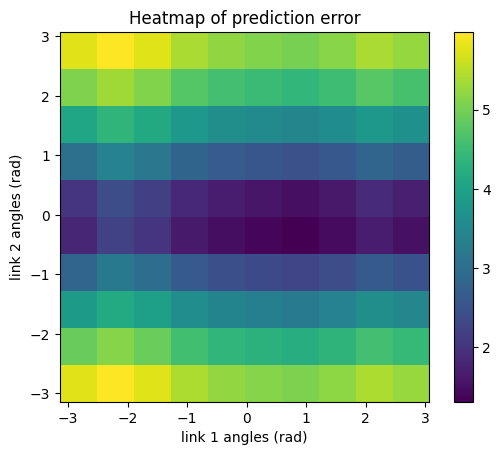

In [12]:
# If working on CodeSpaces, run this cell before running the next model to free up memory
if not AUTOGRADING:
    model_theta_scripted = torch.jit.script(model_theta)
    model_theta_scripted.save(str(statedicts_dir / "task_1-1_model_theta.pt"))

    %xdel train_loader_theta
    %xdel val_loader_theta
    %xdel test_loader_theta
    %xdel model_theta_scripted

    _, test_dataset_theta = load_test_dataset_dataloader(
        str(datasets_dir / "dataset_double_pendulum_test.npz"),
        _rng=init_rng,
        model_type="theta",
    )

    evaluate_model(
        model_theta,
        test_dataset_theta,
        model="theta",
        file="task_1-1_model_theta_prediction_error.pdf",
    )

    %xdel model_theta
    %xdel test_dataset_theta

### 1.1 - Analyse Model performance (4p)
Analyze the prediction accuracy of the model on the test data from heat map of the loss outputted from the `evaluate_model` function. Where does this model have the lowest accuracy? What could be an explanation for the loss of accuracy in those regions? **2p** (Answer in the cell below)

Answer: The heatmap shows the error of prediction results, the lighter the colour, the bigger the mistake. From the heatmap, we are able to notice that most of the errors, namely low accuracy, are distributed in the corner. In reality, this distribution can be interpreted as when link 1 and link 2 both have relatively large angles. There could be two explanations for the low accuracy:


1. The network is poorly trained for that scenario. In that regard, we need to collect more data when link 1 and link 2 share great angle displacement and train the network based on the collected data.
2. Our network fails to learn the pattern for the case since it is highly nonlinear. From a mathematical point of view, we are able to linearize the model of a single pendulum for small displacement. However, when the angle increases to a certain level, the model becomes highly nonlinear. As a result, the easily-formed network fails to learn the pattern.

In general, a separate test dataset is used to evaluate a trained model. Why? **(2p)** (Answer in the cell below)

We used a separate test dataset to evaluate a trained model to increase the generalized capability of the model. Because the goal of the built neural network is to minimize the loss of function on the training set, we can expect a good prediction on the training set. However, it doesn’t mean that the model is good at predicting something that it hasn’t seen before. Therefore, a separate test dataset is necessary for model assessment.


## Task 1.2: Indirectly predict the angle
We are going to improve the accuracy by pre-processing the target data. Specifically, we will create a model $M_{trig}$ that learns to predict $\sin(\theta)$ and $\cos(\theta)$ for both links instead of directly predicting $\theta$. Then, we can use the trigonometric relation to retrieve an estimate of $\theta$ for both links.

Note: In practice you would use the `atan2` implementation, as the regular arctangent only covers $[-\frac{1}{2}\pi, \frac{1}{2}\pi]$} $\theta=\arctan(\frac{\sin(\theta)}{\cos(\theta)})$ 

### 1.2 Prepare the data (0p)

Run the functions below to load the data generated in `task_1a_generate_data.ipynb`, split the training into the 70/30 train/validation split, set the batch size to and put them in a dataloader. The data is first put in the class `TrigDataset`. This class again converts the `uint8` pixel values from a range of 0-255 to float values in the range `0-1` while also calculating the values of $\mathrm{sin}(\theta_1), \mathrm{sin}(\theta_2), \mathrm{cos}(\theta_1), \mathrm{cos}(\theta_2)$ to be used as labels instead of just $\theta_1, \theta_2$ as was done in the `ThetaDataset` class. The dataloader is again set to shuffle the data randomly before enumerating during the training loop.

In [13]:
if not AUTOGRADING:
    train_loader_trig, val_loader_trig = load_training_dataset_dataloader(
        datasets_dir / "dataset_double_pendulum_train.npz",
        _rng=init_rng,
        model_type="trig",
    )
    test_loader_trig, _ = load_test_dataset_dataloader(
        datasets_dir / "dataset_double_pendulum_test.npz",
        _rng=init_rng,
        model_type="trig",
    )

Trig Dataset


### 1.2 - Create the model (1.5p)

Copy the model you created in Task 1.1. Change the number of hidden units of the final layer from 2 to 4. We do so, because we now want to predict two outputs ($\sin(\theta)$, $\cos(\theta)$) for both link angles, instead of only two outputs, $\theta_1$ and $\theta_2$.

In [14]:
""" TASK 1.2: CREATE MODEL HERE """


class NeuralNetworkTrig(nn.Module):
    def __init__(self):
        super().__init__()
        # YOUR CODE HERE
        self.flatten = nn.Flatten()                    
        self.linear1 = nn.Linear(32*32*3, 128)          # input dimension if UNKOWN
        self.act_fn = nn.ReLU()
        self.linear2 = nn.Linear(128, 4)                # change the final layer from 2 t o4
    def forward(self, x):
        #print(x.size)                                   # see dimension of input 
        x = self.flatten(x)
        #print(x.size)
        x = self.linear1(x)
        x = self.act_fn(x)
        x = self.linear2(x)
        return x
"""TASK1.2: END"""

model_trig = NeuralNetworkTrig()
total_params_trig = sum(p.numel() for p in model_trig.parameters())
print("Total number of neural network parameters: ", total_params_trig)

Total number of neural network parameters:  393860


### 1.2 - Train the model (2p)

Now train a model with the same training parameters defined below as in task 1.1 but using the training data `train_loader_trig`. Tune the learning rate in the optimizer to give the best performance on the validation and test set over the 100 epochs. Do this 10 times and record the prediction error of the final model of each of the 10 runs on the test dataset `test_loader_trig` using the function `evaluate_model_test_data_trig`. **Hint:** 
- reduce the number of epochs and lower the number of runs to `1` while getting your model working. 
- The try in the range `1e-1` to `1e-5` for the learning rate

In [15]:
# Training parameters
optimizer = torch.optim.SGD(model_trig.parameters(), lr=1e-3)
loss_fn = torch.nn.MSELoss()
error_fn = torch.nn.L1Loss()
num_epochs = 100


def evaluate_model_test_data_trig(_model, _test_loader):
    running_loss_test = 0.0
    running_error_test = 0.0
    count = 0
    with torch.no_grad():
        for i, data_test in enumerate(_test_loader):
            count += 1
            inputs_test, labels_test = data_test
            batch = labels_test.shape[0]
            est = _model(inputs_test)
            est_th = trig_to_theta(est)
            label_th = trig_to_theta(labels_test)
            loss_test = loss_fn(est_th, label_th)
            error_test = error_fn(est_th, label_th)
            running_loss_test += loss_test.item()
            running_error_test += error_test.item()
    print(
        f"Loss on test data: {running_loss_test / count:.3f}, Prediction error of model on test data: {running_error_test / count:.3f}"
    )

    return running_error_test / count

In [16]:
from tqdm import tqdm
if not AUTOGRADING:
    """TASK 1.2: TRAIN MODEL HERE"""
    num_runs = 10
    pred_error_trig = onp.zeros((num_runs))

    for run in range(num_runs):
        model_trig = NeuralNetworkTrig()
        optimizer = torch.optim.SGD(model_trig.parameters(), lr=1e-3)
        # YOUR CODE HERE

        for epoch in tqdm(range(num_epochs)):
            for data_inputs, data_labels in train_loader_trig:
                ## Step 1: Move input data to device (only strictly necessary if we use GPU)
                device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
                data_inputs = data_inputs.to(device)
                data_labels = data_labels.to(device)

                ## Step 2: Run the model on the input data
                preds = model_trig(data_inputs)
                preds = preds.squeeze(
                    dim=1
                )  # Output is [Batch size, 1], but we want [Batch size]

                ## Step 3: Calculate the loss
                loss = loss_fn(preds, data_labels.float())

                ## Step 4: Perform backpropagation
                # Before calculating the gradients, we need to ensure that they are all zero.
                # The gradients would not be overwritten, but actually added to the existing ones.
                optimizer.zero_grad()
                # Perform backpropagation
                loss.backward()

                ## Step 5: Update the parameters
                optimizer.step()
    
        print(f"run {run+1} finished")
        pred_error_trig[run] = evaluate_model_test_data_trig(
            model_trig, test_loader_trig
        )
    print("average prediction error: ", onp.mean(pred_error_trig))
    """TASK 1.2: END"""

100%|██████████| 100/100 [01:15<00:00,  1.33it/s]


run 1 finished
Loss on test data: 1.626, Prediction error of model on test data: 0.568


100%|██████████| 100/100 [01:14<00:00,  1.34it/s]


run 2 finished
Loss on test data: 2.051, Prediction error of model on test data: 0.627


100%|██████████| 100/100 [01:14<00:00,  1.34it/s]


run 3 finished
Loss on test data: 2.001, Prediction error of model on test data: 0.616


100%|██████████| 100/100 [01:15<00:00,  1.32it/s]


run 4 finished
Loss on test data: 1.773, Prediction error of model on test data: 0.575


100%|██████████| 100/100 [01:13<00:00,  1.36it/s]


run 5 finished
Loss on test data: 1.693, Prediction error of model on test data: 0.559


100%|██████████| 100/100 [01:17<00:00,  1.29it/s]


run 6 finished
Loss on test data: 2.051, Prediction error of model on test data: 0.627


100%|██████████| 100/100 [01:25<00:00,  1.17it/s]


run 7 finished
Loss on test data: 1.706, Prediction error of model on test data: 0.577


100%|██████████| 100/100 [01:18<00:00,  1.28it/s]


run 8 finished
Loss on test data: 1.586, Prediction error of model on test data: 0.565


100%|██████████| 100/100 [01:18<00:00,  1.28it/s]


run 9 finished
Loss on test data: 1.802, Prediction error of model on test data: 0.582


100%|██████████| 100/100 [01:16<00:00,  1.30it/s]


run 10 finished
Loss on test data: 1.608, Prediction error of model on test data: 0.555
average prediction error:  0.5851136603341327


Trig Dataset


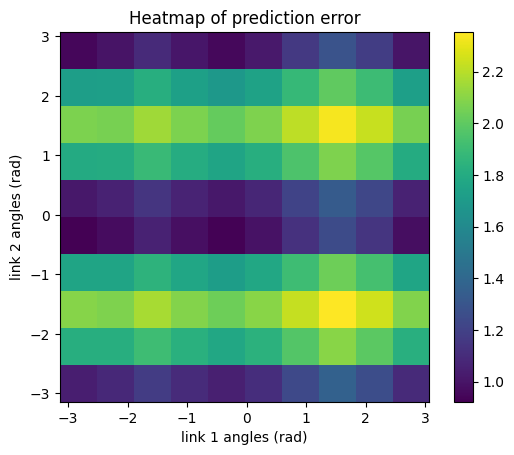

In [17]:
# If working on CodeSpaces, run this cell before running the next model to free up memory
if not AUTOGRADING:
    model_trig_scripted = torch.jit.script(model_trig)
    model_trig_scripted.save(str(statedicts_dir / "task_1-2_model_trig.pt"))

    %xdel train_loader_trig
    %xdel val_loader_trig
    %xdel test_loader_trig
    %xdel model_trig_scripted

    _, test_dataset_trig = load_test_dataset_dataloader(
        datasets_dir / "dataset_double_pendulum_test.npz",
        _rng=init_rng,
        model_type="trig",
    )

    evaluate_model(
        model_trig,
        test_dataset_trig,
        model="trig",
        file="task_1-2_model_trig_prediction_error.pdf",
    )

    %xdel test_dataset_trig
    %xdel model_trig

### 1.2 - Analyse Model performance (4p)
Compare the prediction estimates for $M_{trig}$ with the plot for $M_θ$. Why does indirectly predicting the angle improve the prediction accuracy? **(2p)** (Answer in the cell below)

From the heatmap, we are able to see that the model still has relatively low accuracy when predicting certain situations. However, the bar on the right of the heatmap indicates that the value of error decreases dramatically compared to the old version of NN. One of the explanations could be that, compared to single theta, the sine, and cosine of theta have more features and patterns for the network to learn. Therefore, increase accuracy.


Why is it not sufficient to predict only sin(θ) and use its inverse θ = arcsin(sin(θ)) to get an estimate of the angle? **(2p)**

Mathematically, the sine signal is symmetric to the axis of pi/2. As a result, if only arcsin is adopted, there could be two ambiguous outputs generated by the network.


## Task 1.3: Indirectly predict the angles with a Convolutional Neural Network (10)
Instead of using a vanilla fully-connected neural network, we will build a prediction model $M_{cnn}$ that uses a convolutional neural network (CNN). 

### 1.3 - Prepare the data

Run the functions below to load the data generated in `task_1a_generate_data.ipynb`, split the training into the 70/30 train/validation split, set the batch size to and put them in a dataloader. The data is first put in the class `CNNDataset`. This class again converts the `uint8` pixel values from a range of 0-255 to float values in the range `0-1` while also calculating the values of $\mathrm{sin}(\theta_1), \mathrm{sin}(\theta_2), \mathrm{cos}(\theta_1), \mathrm{cos}(\theta_2)$ to be used as labels instead of just $\theta_1, \theta_2$ as was done in the `ThetaDataset` class. We also permutate the order of the pixel ovbservations from `(number of samples, pixel rows, pixel columns, color channels)` to `(number of samples, color channels, pixel rows, pixel columns, )` as this is the order that the 2d convolution layer expects. The dataloader is again set to shuffle the data randomly before enumerating during the training loop.


In [34]:
if not AUTOGRADING:
    train_loader_cnn, val_loader_cnn = load_training_dataset_dataloader(
        datasets_dir / "dataset_double_pendulum_train.npz",
        _rng=init_rng,
        model_type="cnn",
    )
    test_loader_cnn, _ = load_test_dataset_dataloader(
        datasets_dir / "dataset_double_pendulum_test.npz",
        _rng=init_rng,
        model_type="cnn",
    )

CNN dataset


### 1.3 - Create the model (2p)
Again, create sequential PyTorch model class and define the following architecture with Convolutional and pooling layers. 
- Start with a CNN layer `torch.nn.Conv2d(...)` with 32 filters, kernel size of `3x3` and a ReLU activation function.
- Then add a max pooling layer `torch.nn.MaxPool2d(...)` with a pool size of `2x2`.
- Add another convolutional layer with 10 filters and a ReLU activation function.
- Then add another max pooling layer `torch.nn.MaxPool2d(...)` with a pool size of `2x2`.
- Flatten the output of the pooling layer
- Add a fully connected layer of 30 with a relu activation function.
- Finally, add a fully connected layer without activation. Remember, the number of ouput units must match the dimension of the target data, which is 4 as we will predict the trigonometric function again. 

**note:* No zero padding is needed as the images have enough whitespace at the edges.

In [19]:
"""TASK 1.3: CREATE MODEL HERE"""


# YOUR CODE HERE
class NeuralNetworkCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = torch.nn.Conv2d(3, 32, kernel_size=(3, 3))         # input data: 32*32*3
        self.relu1 = nn.ReLU()
        self.max_pooling1 = torch.nn.MaxPool2d(kernel_size=(2, 2))
        self.conv2 = torch.nn.Conv2d(32, 10, kernel_size=(3, 3))
        self.relu2 = nn.ReLU()
        self.max_pooling2 = torch.nn.MaxPool2d(kernel_size=(2, 2))
        self.flatten = nn.Flatten()
        self.linear1 = nn.Linear(360, 30)                       # Flatten dimension need 2 be certain
        self.relu3 = nn.ReLU()
        self.linear2 = nn.Linear(30, 4)
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.max_pooling1(x)
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.max_pooling2(x)
        x = self.flatten(x)
        x = self.linear1(x)
        x = self.relu3(x)
        x = self.linear2(x)
        
        return x
"""TASK 1.3: END HERE"""

model_cnn = NeuralNetworkCNN()
total_params_cnn = sum(p.numel() for p in model_cnn.parameters())
print("total number of model parameters: ", total_params_cnn)

total number of model parameters:  14740


### 1.3 - Train the model (2p)

Train the model with the same training parameters defined below as in task 1.1 and 1.2 but using the training data `train_loader_cnn`. Again, Tune the learning rate in the optimizer to give the best performance on the validation and test set over the 100 epochs. Do this 10 times and record the prediction error of the final model of each of the 10 runs on the test dataset `test_loader_cnn` using the function `evaluate_model_test_data_cnn`. Don't forget to reinitialize the parameters on each run! **Hints:** 
- reduce the number of epochs and lower the number of runs to `1` while getting your model working. 
- The try in the range of 1e-1 to 1e-5 for the learning rate

#### One last thing!
A Convolutional neural network that can predict angles is required for task 2b. Therefore, focus getting the perfect learning and optimal model accuracy with this Neural Network to see how far you can increase the prediction accuracy of link angles. Be warned, the accuracy of your model will affect the performance of you controller in task 2b.

In [20]:
# Training parameters
optimizer = torch.optim.SGD(model_cnn.parameters(), lr=1e-3)
loss_fn = torch.nn.MSELoss()
error_fn = torch.nn.L1Loss()
num_epochs = 100


def evaluate_model_test_data_cnn(_model, _test_loader):
    """
    evaluates the model_cnn on the
    """
    running_loss_test = 0.0
    running_error_test = 0.0
    count = 0
    with torch.no_grad():
        for i, data_test in enumerate(_test_loader):
            count += 1
            inputs_test, labels_test = data_test
            batch = labels_test.shape[0]
            est = _model(inputs_test)
            est_th = trig_to_theta(est)
            label_th = trig_to_theta(labels_test)
            loss_test = loss_fn(est_th, label_th)
            error_test = error_fn(est_th, label_th)
            running_loss_test += loss_test.item()
            running_error_test += error_test.item()

    print(
        f"Loss on test data: {running_loss_test / count:.3f}, Prediction error of model on test data: {running_error_test / count:.3f}"
    )
    return running_error_test / count

In [21]:
from tqdm import tqdm
if not AUTOGRADING:
    """TASK 1.3: TRAIN MODEL HERE"""

    num_runs = 10                                            # too time consuming for 10, could be changed
    pred_error_cnn = onp.zeros((num_runs))

    for run in range(num_runs):
        model_cnn = NeuralNetworkCNN()
        optimizer = torch.optim.SGD(model_cnn.parameters(), lr=1e-3)
        # YOUR CODE HERE
        for epoch in tqdm(range(num_epochs)):
            for data_inputs, data_labels in train_loader_cnn:
                ## Step 1: Move input data to device (only strictly necessary if we use GPU)
                device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
                data_inputs = data_inputs.to(device)
                data_labels = data_labels.to(device)

                ## Step 2: Run the model on the input data
                preds = model_cnn(data_inputs)
                preds = preds.squeeze(
                    dim=1
                )  # Output is [Batch size, 1], but we want [Batch size]

                ## Step 3: Calculate the loss
                loss = loss_fn(preds, data_labels.float())

                ## Step 4: Perform backpropagation
                # Before calculating the gradients, we need to ensure that they are all zero.
                # The gradients would not be overwritten, but actually added to the existing ones.
                optimizer.zero_grad()
                # Perform backpropagation
                loss.backward()

                ## Step 5: Update the parameters
                optimizer.step()
  
        print(f"run {run+1} finished")
        pred_error_cnn[run] = evaluate_model_test_data_cnn(model_cnn, test_loader_cnn)
    print("average prediction error: ", onp.mean(pred_error_cnn))

    print("Finished Training")

    """TASK 1.3: END"""

100%|██████████| 100/100 [09:55<00:00,  5.96s/it]


run 1 finished
Loss on test data: 1.864, Prediction error of model on test data: 0.575


100%|██████████| 100/100 [09:41<00:00,  5.82s/it]


run 2 finished
Loss on test data: 1.829, Prediction error of model on test data: 0.601


100%|██████████| 100/100 [10:14<00:00,  6.15s/it]


run 3 finished
Loss on test data: 2.561, Prediction error of model on test data: 0.801


100%|██████████| 100/100 [09:48<00:00,  5.88s/it]


run 4 finished
Loss on test data: 2.225, Prediction error of model on test data: 0.694


100%|██████████| 100/100 [10:03<00:00,  6.04s/it]


run 5 finished
Loss on test data: 2.363, Prediction error of model on test data: 0.733


100%|██████████| 100/100 [09:44<00:00,  5.85s/it]


run 6 finished
Loss on test data: 1.686, Prediction error of model on test data: 0.556


100%|██████████| 100/100 [10:04<00:00,  6.05s/it]


run 7 finished
Loss on test data: 1.733, Prediction error of model on test data: 0.562


100%|██████████| 100/100 [09:49<00:00,  5.90s/it]


run 8 finished
Loss on test data: 2.459, Prediction error of model on test data: 0.757


100%|██████████| 100/100 [10:06<00:00,  6.06s/it]


run 9 finished
Loss on test data: 1.787, Prediction error of model on test data: 0.585


100%|██████████| 100/100 [09:52<00:00,  5.93s/it]


run 10 finished
Loss on test data: 2.081, Prediction error of model on test data: 0.643
average prediction error:  0.6506324577753938
Finished Training


CNN dataset


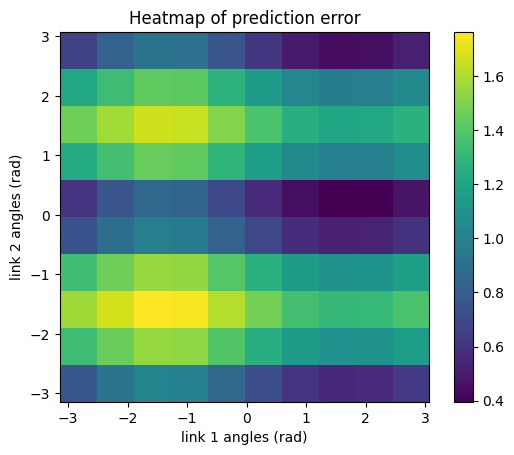

In [22]:
# If working on CodeSpaces, run this cell before running the next model to free up memory
if not AUTOGRADING:
    model_cnn_scripted = torch.jit.script(model_cnn)
    model_cnn_scripted.save(str(statedicts_dir / "task_1-3_model_cnn.pt"))

    %xdel train_loader_cnn
    %xdel val_loader_cnn
    %xdel test_loader_cnn
    %xdel model_cnn_scripted

    _, test_dataset_cnn = load_test_dataset_dataloader(
        datasets_dir / "dataset_double_pendulum_test.npz",
        _rng=init_rng,
        model_type="cnn",
    )

    evaluate_model(
        model_cnn,
        test_dataset_cnn,
        model="cnn",
        file="task_1-3_model_cnn_prediction_error.pdf",
    )

    %xdel test_dataset_cnn
    %xdel model_cnn

### 1.3 - Analyse and Compare Model performance 
Make a comparison of the different models (i.e. M θ, M trig, M cnn) based on the average prediction accuracy
on the test dataset and the number of trainable parameters. Which model would you prefer and why? (answer in the cell below)

Among the three models, I prefer M trig the most since it gives a relatively good and accurate prediction result with reasonable computational cost. For the M theta model, its performance is limited for the simple structure. It can’t be denied that the convolutional neural network has the best performance among all models. However, given the amount of time training spent and the improvement of performance, it is truly costly to use this model in reality. 


If you change the activation of the last fully connected layer to ReLU, the prediction accuracy completely deteriorates. Why?

The poor performance can be attributed to the property of the Relu function which is nonnegative and linear. It should be noted that the Relu function is a perfect activation function within the linear network since it acts like a “trigger” to the neural unit. Nevertheless, for the final layer which establishes the mapping between feature tensors and final outputs, a function that could reflect more relation should be adopted.


## Task 1.4: Variance across runs (2.5p) 
In the previous tasks, the prediction accuracy varied across different runs even though the underlying code and dataset remained unchanged.

Use the code cell below to set the seed for PyTorch. Train the model for a seed of 0 and then for seed of 1, recording the average prediction accuracy and standard deviation for both.  

In [41]:
torch.manual_seed(1)  # set seed to either 0 or 1

In [42]:
if not AUTOGRADING:
    train_loader_theta, val_loader_theta = load_training_dataset_dataloader(
        str(datasets_dir / "dataset_double_pendulum_train.npz"),
        _rng=init_rng,
        model_type="theta",
    )
    test_loader_theta, _ = load_test_dataset_dataloader(
        str(datasets_dir / "dataset_double_pendulum_test.npz"),
        _rng=init_rng,
        model_type="theta",
    )

Theta Dataset


Copy the architecture of $M_{\theta}$ to create a new model below. Don't forget to comment on the code to set the seed again when working on the other tasks.

In [43]:
""" TASK 1.4: CREATE MODEL HERE """
class NeuralNetworkThetaSeed(nn.Module):
    def __init__(self):
        super().__init__()
        # YOUR CODE HERE
        self.flatten = nn.Flatten()                    
        self.linear1 = nn.Linear(32*32*3, 128)          # input dimension if UNKOWN
        self.act_fn = nn.ReLU()
        self.linear2 = nn.Linear(128, 2)                 
    def forward(self, x):
        #print(x.size)                                   # see dimension of input 
        x = self.flatten(x)
        #print(x.size)
        x = self.linear1(x)
        x = self.act_fn(x)
        x = self.linear2(x)
        return x
        # YOUR CODE HERE
"""TASK1.4: END"""
model_theta_seed = NeuralNetworkThetaSeed()

Set up a training loop as done for the task 1.3 and run this 10 times while having the seed value as 0 and then run it again for a seed of 1. Use the same datasets as in task 1.3. **(0.5p)**. 

In [44]:
# Training parameters
optimizer = torch.optim.SGD(model_theta_seed.parameters(), lr=1e-3)
# We choose the mean square loss as it is a regression problem
loss_fn = torch.nn.MSELoss()
num_epochs = 30

num_runs = 10                                        # set to 1 for testing, original for 10
pred_error_seed0 = onp.zeros((num_runs))
pred_error_seed1 = onp.zeros((num_runs))

In [45]:
from tqdm import tqdm
if not AUTOGRADING:
    """TASK 1.4: TRAIN MODEL HERE"""
    for run in range(num_runs):
        model_theta_seed = NeuralNetworkThetaSeed()
        optimizer = torch.optim.SGD(model_theta_seed.parameters(), lr=1e-3)
        # YOUR CODE HERE
        for epoch in tqdm(range(num_epochs)):
            for data_inputs, data_labels in train_loader_theta:               # use the same data as 1.3
                ## Step 1: Move input data to device (only strictly necessary if we use GPU)
                device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
                data_inputs = data_inputs.to(device)
                data_labels = data_labels.to(device)

                ## Step 2: Run the model on the input data
                preds = model_theta_seed(data_inputs)
                preds = preds.squeeze(
                    dim=1
                )  # Output is [Batch size, 1], but we want [Batch size]

                ## Step 3: Calculate the loss
                loss = loss_fn(preds, data_labels.float())

                ## Step 4: Perform backpropagation
                # Before calculating the gradients, we need to ensure that they are all zero.
                # The gradients would not be overwritten, but actually added to the existing ones.
                optimizer.zero_grad()
                # Perform backpropagation
                loss.backward()

                ## Step 5: Update the parameters
                optimizer.step()
                
        print(f"run {run+1} finished")

        # When seed == 0
        #pred_error_seed0[run] = evaluate_model_test_data_theta(model_theta_seed, test_loader_theta)
        
        # When seed == 1
        pred_error_seed1[run] = evaluate_model_test_data_theta(model_theta_seed, test_loader_theta)

    # When seed == 0    
    #print("average prediction error: ", onp.mean(pred_error_seed0))             # mean of overall run
    #print("deviation prediction error:", onp.std(pred_error_seed0))             # std of overall run
    
    # When seed == 1
    print("average prediction error: ", onp.mean(pred_error_seed1))            # mean of overall run
    print("deviation prediction error:", onp.std(pred_error_seed1))            # std of overall run
    
    """TASK 1.4: END"""

100%|██████████| 30/30 [00:16<00:00,  1.79it/s]


run 1 finished
Loss on test data: 1.399, Prediction error of model on test data: 0.828


100%|██████████| 30/30 [00:15<00:00,  1.89it/s]


run 2 finished
Loss on test data: 1.463, Prediction error of model on test data: 0.767


100%|██████████| 30/30 [00:16<00:00,  1.81it/s]


run 3 finished
Loss on test data: 1.375, Prediction error of model on test data: 0.764


100%|██████████| 30/30 [00:16<00:00,  1.86it/s]


run 4 finished
Loss on test data: 1.384, Prediction error of model on test data: 0.752


100%|██████████| 30/30 [00:15<00:00,  1.88it/s]


run 5 finished
Loss on test data: 1.634, Prediction error of model on test data: 0.801


100%|██████████| 30/30 [00:16<00:00,  1.81it/s]


run 6 finished
Loss on test data: 1.644, Prediction error of model on test data: 0.885


100%|██████████| 30/30 [00:15<00:00,  1.91it/s]


run 7 finished
Loss on test data: 1.459, Prediction error of model on test data: 0.799


100%|██████████| 30/30 [00:15<00:00,  1.89it/s]


run 8 finished
Loss on test data: 1.455, Prediction error of model on test data: 0.786


100%|██████████| 30/30 [00:15<00:00,  1.90it/s]


run 9 finished
Loss on test data: 1.503, Prediction error of model on test data: 0.774


100%|██████████| 30/30 [00:15<00:00,  1.89it/s]

run 10 finished
Loss on test data: 1.523, Prediction error of model on test data: 0.844
average prediction error:  0.7998716803751592
deviation prediction error: 0.039296435719076914


Theta Dataset


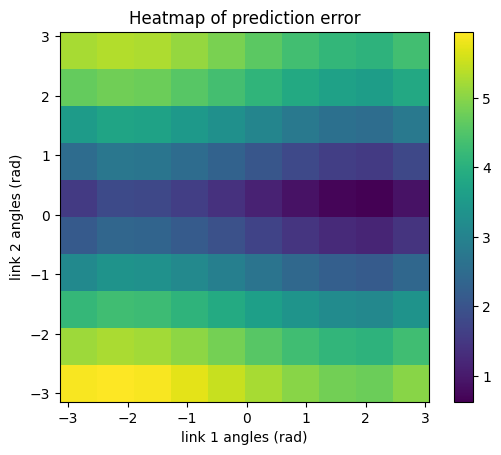

In [46]:
# If working on CodeSpaces, run this cell before running the next model to free up memory
if not AUTOGRADING:
    model_theta_scripted = torch.jit.script(model_theta_seed)
    # Save your models
    model_theta_scripted.save(str(statedicts_dir / "task_1-4_model_theta_seed0.pt"))
    model_theta_scripted.save(str(statedicts_dir / "task_1-4_model_theta_seed1.pt"))

    %xdel train_loader_theta
    %xdel val_loader_theta
    %xdel test_loader_theta
    %xdel model_theta_scripted

    _, test_dataset_theta = load_test_dataset_dataloader(
        str(datasets_dir / "dataset_double_pendulum_test.npz"),
        _rng=init_rng,
        model_type="theta",
    )

    evaluate_model(
        model_theta_seed,
        test_dataset_theta,
        model="theta",
        file="task_1-4_model_theta_prediction_error.pdf",
    )

- What do you observe? (1p)

- What is the benefit of seeding the pseudo-random generator in practice? **(1p)**

Write your answers in the cell below

I analyzed the effect of setting different seeds (0 or 1) by manual changing the value of seed and running the network multiple times (3) and recorded the final mean and standard deviation of the prediction error. Records of data are listed below:

| | Seed0 | Seed1 | Seed0 | Seed1 | Seed0 | Seed1 |
| --- | --- | --- | --- | --- | --- | --- |
| Mean | .793 | .799 | .799 | .799 | .799 | .799|
| Std | .040| .039 | .050 | .039 | .050 | .039 |

From the above table, it is noticed that the value of mean doesn't vary, or only varies in a small range when seed is changed. However, the standard deviation varied from .039 to .050. Thus, from my experiment, changing the seed will not improve the accuracy but make the prediction result more stable. Further search into the internet gives us two effects of setting seed:

1. The seed controls the initial values of a network weights and biases.
2. The seed controls the order in which training data is processed by a DataLoader object.

## Task 1.5: Spiking neural networks (15p)

If our goal is to control the double pendulum, the angular velocity $\dot{\theta}$ is generally also required. However, temporal information cannot be extracted from individual images. We are going to utilize the temporal advantage of the spiking neural networks (SNN) to predict the angular velocity of each link. Instead of static individual images, we adopt event-based data as the input.

### 1.5 - Warm Up
Use the Jupyter notebook `task_1-5_SNN_warmup.ipynb` to understand the neuron structure of SNNs, construct a LIF neuron model and a simple fully connected SNN.

### 1.5 - Prepare the dataset

In this part, the dataloader has been defined, and the two data sets `train_loader_snn` and `test_loader_snn` have been generated, which can be directly used to train the network. The two datasets are the same size. The batch_size has chosen 16. And we shuffle the dataset by setting shuffle to true. At the same time, to make the size of the data set just divisible by batch_size, we set drop_last to true to discard the last set of data that is less than one batch. At the same time, we did not set the validation set.

Therefore, the size of each piece of data in dataloader is: （batch_size: 16, time_step: 20, channels: 2, size: 32, size: 32）.

In [8]:
# This part has to be same as task_1a_generate_data.ipynb
train_th1_range = jnp.arange(-jnp.pi / 6.0, jnp.pi / 6.0, jnp.pi / 30.0)
train_th2_range = jnp.arange(-jnp.pi, jnp.pi, jnp.pi / 6.0)
test_th1_range = jnp.arange(-jnp.pi / 6.0, jnp.pi / 6.0, jnp.pi / 30.0)
test_th2_range = jnp.arange(-jnp.pi, jnp.pi, jnp.pi / 6.0)

TRAIN_NUM_DATA = len(train_th1_range) * len(train_th2_range)
TEST_NUM_DATA = len(test_th1_range) * len(test_th2_range)
NUM_SNN_DATA = 5

In [9]:
if not AUTOGRADING:
    train_set_snn = SNNDataset(
        datasets_dir / "event_based_data" / "train",
        TRAIN_NUM_DATA,
        NUM_SNN_DATA,
    )
    train_loader_snn = DataLoader(
        train_set_snn, batch_size=16, shuffle=True, drop_last=True
    )

    test_set_snn = SNNDataset(
        datasets_dir / "event_based_data" / "test",
        TEST_NUM_DATA,
        NUM_SNN_DATA,
    )
    test_loader_snn = DataLoader(
        test_set_snn, batch_size=16, shuffle=True, drop_last=True
    )

### 1.5 - Create the model (4p)

We create a class called `snnModel` extending `nn.Module`. Please fill this class to implement the model of SNNs. We adopt the LIF model for neurons.

The structure of the network is like:

* Start with a convolutional layer with 16 as the number of output channels, kernel size of `5x5`.
* Then, add a max pooling layer with a pooling size of `4x4`.
* Add the second convolutional layer with 16 as output channel size, kernel size of `3x3`.
* Add the third convolutional layer with 16 as output channel size, kernel size of `3x3`.
* All neurons use LIF model, and obtain the membrane potential in a recurrent way.
* Flatten the membrane potential in the last layer and feed it into two fully connected layers with the ReLU activation fuction in between. We recommend the input size of the second fully connected layer is 640. The final output number must match the dimension of our target data which is 2.

Meanwhile, for LIF model, we use `fast_sigmoid` function as the surrogate function, and the decay rate `beta` is 0.8. It is worth noting that we need to use the recurrent method to process event-based data. So,

* We should use the for-loop to traverse each time step of the input event-based data. For the data of each time step, we can use the convolution operation to process the data as usual. Each convolution operation is followed by a layer of SNN neurons. Finally, the membrane potential of the last layer of all time steps is used as output. Therefore, the expected output format of the SNN part should be `[batch_size: 16, time_step: 20, conv_channel: (should be the channel size of the last convolutional layer), size: (output size), size: (output size)]`.
* The first dimension of the input data is batch size, but not the time steps. So we need to transpose the input tensor first and then use for-loop to process it.
* The final non-linear layer (two fully connected layers with ReLU) should be the conventional neurons instead of SNN neurons.
* Do not forget to initialize the LIF neurons!

In [10]:
# YOUR CODE HERE
from snntorch import spikeplot as splt
from snntorch import surrogate

class snnModel(nn.Module):
    def __init__(
        self, beta=0.8, time_steps=20                    # setting decay rate and time step
    ):
        super().__init__()
        self.beta = 0.8
        self.time_steps = 20
        spike_grad = surrogate.fast_sigmoid()
        self.conv1 = torch.nn.Conv2d(2, 16, kernel_size=(5, 5))
        self.max_pool1 = torch.nn.MaxPool2d(kernel_size=(4, 4))
        self.lif1 = snn.Leaky(beta=beta, spike_grad=spike_grad) 

        self.conv2 = torch.nn.Conv2d(16, 16, kernel_size=(3, 3))
        self.lif2 = snn.Leaky(beta=beta, spike_grad=spike_grad) 

        self.conv3 = torch.nn.Conv2d(16, 16, kernel_size=(3, 3))
        self.lif3 = snn.Leaky(beta=beta, spike_grad=spike_grad) 

        self.flatten = torch.nn.Flatten()
        self.linear1 = torch.nn.Linear(2880, 640)         
        self.relu1 = torch.nn.ReLU()
        self.linear2 = torch.nn.Linear(640, 2)

    def forward(self, x):
        # Initialize the LIF neurons
        mem1 = self.lif1.init_leaky()
        mem2 = self.lif2.init_leaky()
        mem3 = self.lif3.init_leaky()
        mem3_record = []

        # input data in the recurrent way
        x = torch.transpose(x, 0, 1)                    # time, bs, channel, length, width (20,16,2,32,32)
        for t in range(20):
            a = x[t,:,:,:,:]                                # 16, 2, 32, 32
            x_single_time = self.conv1(a)                               
            current1 = self.max_pool1(x_single_time)   
            #print(current1.size())                 
            spk1, mem1 = self.lif1(current1, mem1)

            current2 = self.conv2(spk1)
            spk2, mem2 = self.lif2(current2, mem2)

            current3 = self.conv3(spk2)
            spk3, mem3 = self.lif3(current3, mem3)
            mem3_record.append(mem3)

        snn_output = torch.stack(mem3_record, dim=0)
        x = torch.transpose(snn_output, 0, 1)               # flip back
        x = self.flatten(x)
        x = self.linear1(x)
        x = self.relu1(x)
        x = self.linear2(x)
        return x     
"""TASK1.5: END"""

model_snn = snnModel()

### 1.5 - Train the model (3p)

Train the SNN model in the same way with other models. We recommend using `1e-3` as the learning rate and training the model for 200 epochs.

In [22]:
optimizer = torch.optim.Adam(model_snn.parameters(), lr=1e-3)
loss_fn = torch.nn.MSELoss()
num_epochs = 200                # original 200

100%|██████████| 200/200 [19:03<00:00,  5.72s/it]


run 1 finished


100%|██████████| 200/200 [19:04<00:00,  5.72s/it]


run 2 finished


100%|██████████| 200/200 [18:24<00:00,  5.52s/it]


run 3 finished
Finished Training


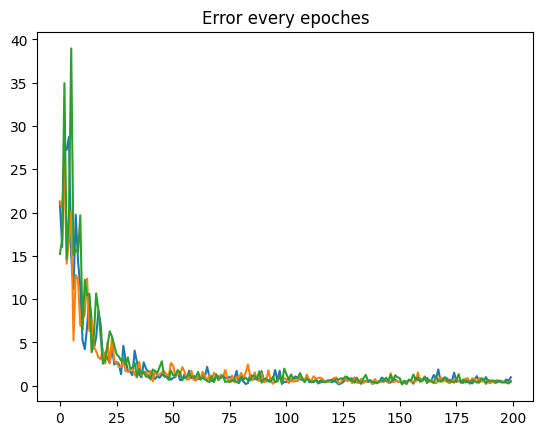

In [23]:
from tqdm import tqdm
onp.random.seed(42)
torch.manual_seed(42)
if not AUTOGRADING:
    """TASK 1.5: TRAIN MODEL HERE"""
    # YOUR CODE HERE
    num_runs = 3                                            
    pred_error_snn = onp.zeros((num_epochs))

    for run in range(num_runs):
        model_snn = snnModel()
        optimizer = torch.optim.Adam(model_snn.parameters(), lr=1e-3)
        for epoch in tqdm(range(num_epochs)):
            for data_inputs, data_labels in train_loader_snn:
                ## Step 1: Move input data to device (only strictly necessary if we use GPU)
                device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
                data_inputs = data_inputs.to(device)
                data_labels = data_labels.to(device)
                
                ## Step 2: Run the model on the input data
                preds = model_snn(data_inputs)
                preds = preds.squeeze(
                    dim=1
                )  # Output is [Batch size, 1], but we want [Batch size]

                ## Step 3: Calculate the loss
                loss = loss_fn(preds, data_labels.float())

                ## Step 4: Perform backpropagation
                # Before calculating the gradients, we need to ensure that they are all zero.
                # The gradients would not be overwritten, but actually added to the existing ones.
                optimizer.zero_grad()
                # Perform backpropagation
                loss.backward()

                ## Step 5: Update the parameters
                optimizer.step()

            print_loss = 0.0
            count = 0

            # check loss
            for i, (events, targets) in enumerate(test_loader_snn):
                output = model_snn(events)
                loss_single = loss_fn(output, targets)
                print_loss += loss.item()
                count = count + 1
                pred_error_snn[epoch] = loss_single

        # plot change of         
        plt.plot(pred_error_snn)    
        plt.title("Error every epoches")

        print(f"run {run+1} finished")
        #pred_error_snn[run] = evaluate_model_test_data_cnn(model_cnn, test_loader_cnn)
    #print("average prediction error: ", onp.mean(pred_error_cnn))

    print("Finished Training")
    """TASK 1.5: END"""

In [24]:
# Evaluate the SNN model with test data
if not AUTOGRADING:
    torch.save(model_snn.state_dict(), str(statedicts_dir / "task_1-5_model_snn.pt"))

    with torch.no_grad():
        model_snn = model_snn.eval()
        print_loss = 0.0
        count = 0
        for i, (events, targets) in enumerate(test_loader_snn):
            output = model_snn(events)
            loss = loss_fn(output, targets)
            print_loss += loss.item()
            count = count + 1

        print_loss = print_loss / count
        print(f"The MSE loss of the model on the test dataset is: {print_loss}")

The MSE loss of the model on the test dataset is: 0.5500853005293254


### 1.5 - Analysis of results (8p)

Does your loss decrease step by step? During the training process, is the training speed faster or slower comparing to CNN and why? Please analyse the advantages and disadvantages of SNN. **(8p)**

From the chart shown above where the loss records of three running times were plotted, it is able to notice that the loss decreased epoch by epoch. 

Compared to the CNN that we built in task 1.3, the SNN shows a faster training speed. Statistically, the average time per training iteration is equal to 5.964 seconds. Whereas the SNN one is 2.96 seconds. However, I think whether SNN is really faster than CNN should be furtherly testified with the same experimental environment and the same amount of parameters. One possible explanation for the fast training speed is that SNN only fires a limited amount of neurons that have been activated above the threshold instead of firing all of them. It is sort similar to the dropout regularization that is ubiquitously used in the nowadays deep learning field. 

In terms of pros and cons for SNN.
Pros:

    1. It is high efficient by setting threshold
    2. It is more similar biologically by taking time into consideration
    
Cons:
	
    It needs specific training and energy to build the model compared to CNN or NN.
